# <span style="color:red">5. Solution</span>

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# 1. The Factors

### 1. 

Describe how each of the factors (other than MKT) is measured. Is the factor portfolio...
* long-only
* long-short
* value-weighted
* equally-weighted

### 2. 

Use the data found in `factor_pricing_data.xlsx`.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.
* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
* The sheet also contains data on five additional factors.
* All factor data is already provided as excess returns

Show the following for each factor:
* mean
* volatility
* Sharpe

### 3. 

Report the correlation matrix across the six factors.

***

# <span style="color:red">1.</span>

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [3]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import performanceMetrics, tailMetrics, get_ols_metrics
#from risk import *
from porttools import heatmap_vector, scatterplot_outliers_iqr

In [4]:
SAMPLING = 'monthly'
FILE = f'../data/factor_pricing_data_{SAMPLING}.xlsx'

SHEET_FACS = 'factors (excess returns)'
SHEET_PORTS = 'portfolios (excess returns)'

if SAMPLING == 'monthly':
    FREQ = 12
elif SAMPLING == 'weekly':
    FREQ = 52
elif SAMPLING == 'daily':
    FREQ = 252

ports_raw = pd.read_excel(FILE,sheet_name=SHEET_PORTS).set_index('Date')
facs_raw = pd.read_excel(FILE,sheet_name=SHEET_FACS).set_index('Date')

ports, facs = ports_raw.align(facs_raw,axis=0,join='inner')

T,N = ports.shape
K = facs.shape[1]


### <span style="color:red">1.1.</span>

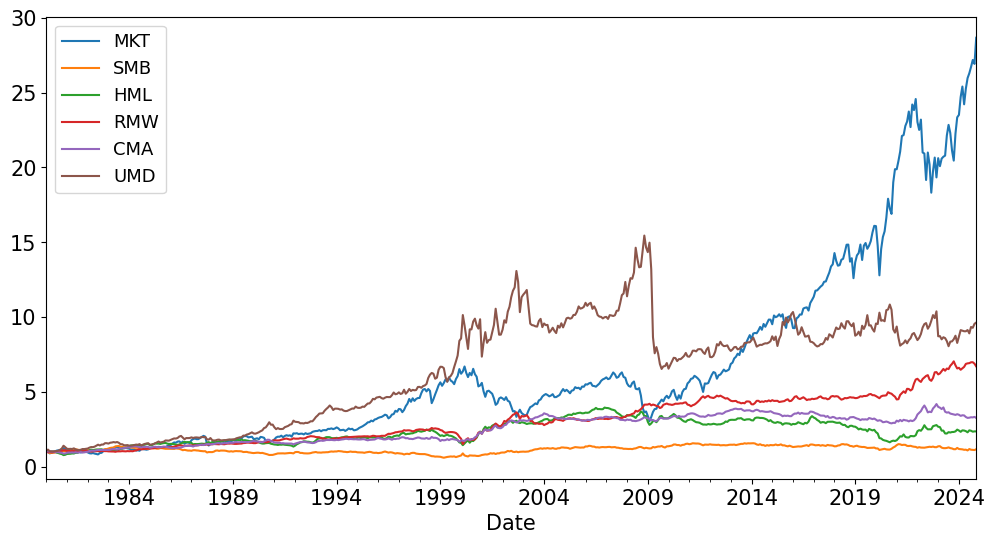

In [5]:
(facs+1).cumprod().plot()
plt.show()

### <span style="color:red">1.2.</span>

In [6]:
performanceMetrics(facs,annualization=FREQ)

,Mean,Vol,Sharpe,Min,Max
MKT,0.0874,0.1567,0.5577,-0.2324,0.1365
SMB,0.0089,0.1019,0.0876,-0.1532,0.1828
HML,0.0253,0.1098,0.2302,-0.1388,0.1280
RMW,0.0460,0.0831,0.5527,-0.1865,0.1307
CMA,0.0291,0.0730,0.3982,-0.0720,0.0907
UMD,0.0630,0.1542,0.4086,-0.3430,0.1820


### <span style="color:red">1.3.</span>

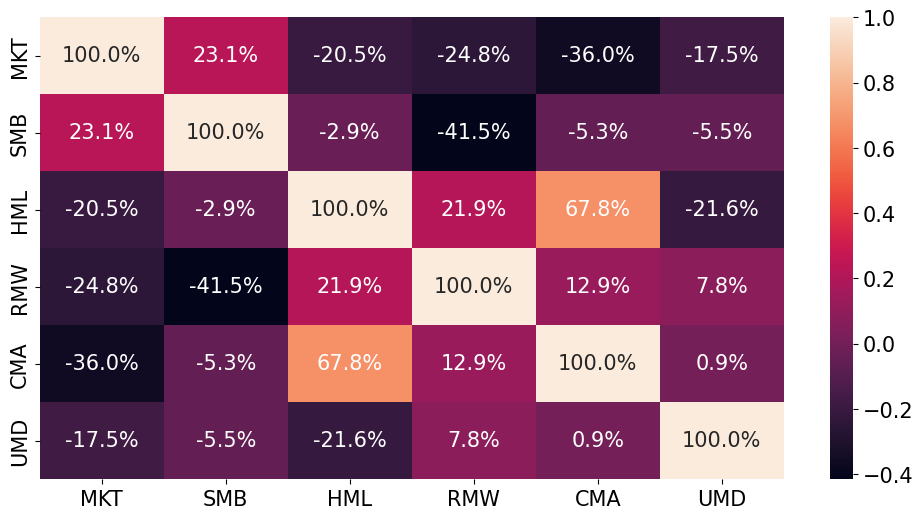

In [7]:
sns.heatmap(facs.corr(),annot=True,fmt='.1%')
plt.show()

***

# 2. Testing Factor-Pricing Models

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* 4-Factor: MKT, HML, RMW, UMD

For instance, for the 4-Factor model is...

![](../refs/LFP-4-factors.png)

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the 4-Factor model:

![](../refs/LFD-4-factors.png)

Data
* PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . , 49.$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

### 1. Test the CAPM

* For each regression, report the estimated alpha and r-squared.
* Calculate the mean of the absolute value of the estimated alphas.
* If the pricing model worked, should these alpha estimates be large or small? Why?


### 2. Test the 4-Factor Model.
   
Report the same statistics as above, in testing the CAPM.

***

# <span style="color:red">2.</span>

### <span style="color:red">2.1. - 2.2.</span>

In [8]:
errors = pd.DataFrame(index=['CAPM','Fama-French','4-Factor'],columns=['mean abs alpha'],dtype=float)

models = dict({
    'CAPM': ['MKT'],
    'Fama-French': ['MKT','SMB','HML'],
    '4-Factor': ['MKT','HML','RMW','UMD']
    })

tab = dict()
for model in models:
    tab[model] = get_ols_metrics(facs[models[model]],ports,annualization=FREQ)
    errors.loc[model,'mean abs alpha'] = tab[model]['alpha'].abs().mean()

,mean abs alpha
CAPM,2.01%
Fama-French,2.34%
4-Factor,2.29%


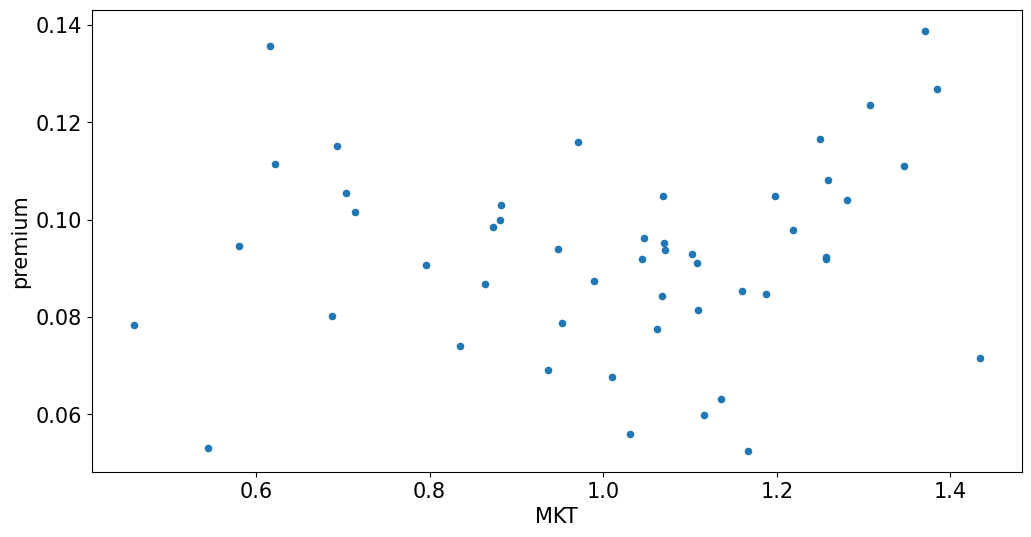

In [9]:
display(errors.style.format('{:.2%}'))

comp = pd.concat([ports.mean()*FREQ,tab['CAPM']['MKT']],axis=1).rename(columns={0:'premium'})
comp.plot.scatter(x='MKT',y='premium')
plt.show()

***

# Extra: Test on S&P 500 Stocks

Must use `weekly` data, so re-import the factor data at this frequency.

In [10]:
SAMPLING = 'weekly'

FILE_STOCKS = f'../data/spx_returns_{SAMPLING}.xlsx'
SHEET_STOCKS = 's&p500 rets'

FILE = f'../data/factor_pricing_data_{SAMPLING}.xlsx'
SHEET_FACS = 'factors (excess returns)'

if SAMPLING == 'monthly':
    FREQ = 12
elif SAMPLING == 'weekly':
    FREQ = 52
elif SAMPLING == 'daily':
    FREQ = 252

stocks_raw = pd.read_excel(FILE_STOCKS, sheet_name=SHEET_STOCKS).set_index('date')
facs_sp500_raw = pd.read_excel(FILE,sheet_name=SHEET_FACS).set_index('Date')

# need risk-free rate to make stock returns into excess returns
rf_sp500_raw = pd.read_excel(FILE,sheet_name='risk-free rate').set_index('Date')
facs_sp500_raw = pd.concat([facs_sp500_raw, rf_sp500_raw],axis=1)
# align the dates
stocks, facs_sp500 = stocks_raw.align(facs_sp500_raw,axis=0,join='inner')
# excess returns
stocks = stocks.sub(facs_sp500['RF'],axis=0)

T,N = stocks.shape
K = facs_sp500.shape[1]

In [11]:
errors = pd.DataFrame(index=['CAPM','Fama-French','4-Factor'],columns=['mean abs alpha'],dtype=float)

tab = dict()
for model in models:
    tab[model] = get_ols_metrics(facs_sp500[models[model]],stocks,annualization=FREQ)
    errors.loc[model,'mean abs alpha'] = tab[model]['alpha'].abs().mean()

In [12]:
display(errors.style.format('{:.2%}'))

,mean abs alpha
CAPM,6.41%
Fama-French,6.25%
4-Factor,6.26%


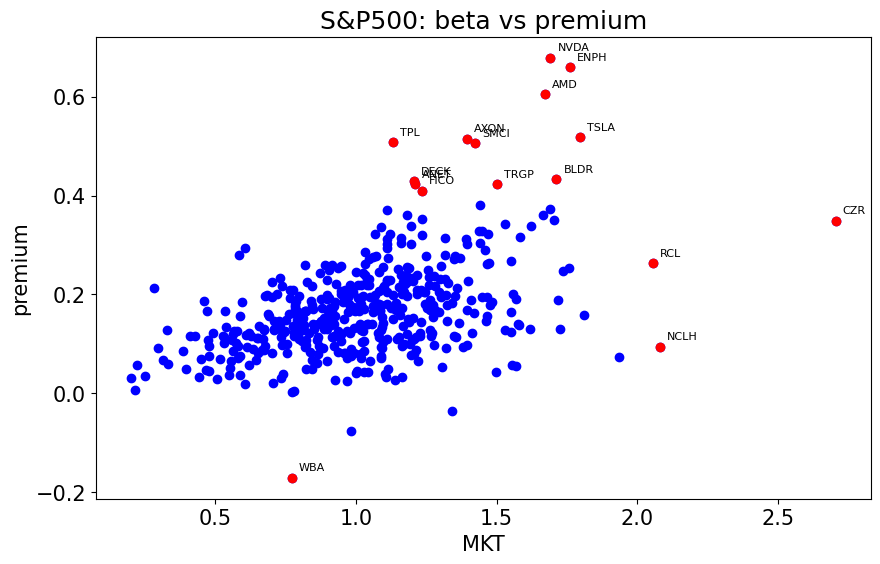

In [13]:
comp = pd.concat([stocks.mean()*FREQ,tab['CAPM']['MKT']],axis=1).rename(columns={0:'premium'})
scatterplot_outliers_iqr(comp,col_x='MKT',col_y='premium',figsize=(10,6),title='S&P500: beta vs premium',k=2)